## Imports

In [1]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

## Load training data

In [2]:
X_emb = np.load("processed_train/X_emb.npy", allow_pickle=True)
Xt_emb = np.load("processed_train/Xt_emb.npy", allow_pickle=True)
yr = np.load("processed_train/yr.npy", allow_pickle=True)
ys =np.load("processed_train/ys.npy", allow_pickle=True)
yr = yr.astype('float64') 
ys = ys.astype('float64') 

y = np.concatenate((np.transpose([yr]), np.transpose([ys])), axis=1)

print(f"type(X_emb)-->{type(X_emb)}")
print(f"type(Xt_emb)-->{type(Xt_emb)}")
print(f"type(ys)-->{type(ys)}")
print(f"type(yr)-->{type(yr)}\n")

print(f"y.shape-->{y.shape}")
print(f"type(y)-->{type(y)}\n")

print(f"X_emb.shape-->{X_emb.shape}")
print(f"Xt_emb.shape-->{Xt_emb.shape}")
print(f"ys.shape-->{ys.shape}")
print(f"yr.shape-->{yr.shape}")

type(X_emb)--><class 'numpy.ndarray'>
type(Xt_emb)--><class 'numpy.ndarray'>
type(ys)--><class 'numpy.ndarray'>
type(yr)--><class 'numpy.ndarray'>

y.shape-->(1400, 2)
type(y)--><class 'numpy.ndarray'>

X_emb.shape-->(1400, 868, 300)
Xt_emb.shape-->(200, 868, 300)
ys.shape-->(1400,)
yr.shape-->(1400,)


## LSTM

In [3]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Bidirectional
from keras.optimizers import Adam

import keras.backend as K
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_emb, y, test_size=0.1, shuffle= True, random_state=42)


# model initialization
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape = (X_emb.shape[1], X_emb.shape[2])))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy',
              #optimizer='adam',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])
# model summary
#model.build(input_shape = (64, X_emb.shape[1], X_emb.shape[2]))
model.summary()

2023-10-27 00:08:16.016786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 00:08:27.896369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 2)                 50        
                                                                 
Total params: 190,026
Trainable params: 190,026
Non-trainable params: 0
_________________________________________________________________


In [4]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=8, restore_best_weights=True)

cb_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=0,
    min_lr=1e-4,
)

bf = model.fit(x=X_train, y=y_train, validation_data = (X_val, y_val), epochs=50, batch_size=32, callbacks=[es, cb_plateau] )

Epoch 1/50
40/40 [==============================] - 72s 2s/step - loss: 0.6530 - accuracy: 0.6000 - val_loss: 0.6693 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 62s 2s/step - loss: 0.5826 - accuracy: 0.5921 - val_loss: 0.6627 - val_accuracy: 0.3929 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 33s 834ms/step - loss: 0.5746 - accuracy: 0.6389 - val_loss: 0.5482 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 34s 848ms/step - loss: 0.4906 - accuracy: 0.7056 - val_loss: 0.4508 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 34s 855ms/step - loss: 0.5382 - accuracy: 0.6611 - val_loss: 0.5317 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.6706
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
40/40 [==============================] - 39s 969ms/step 

### Metrics

In [5]:
# best epoch obtained
results_test = model.evaluate(X_val, y_val)
print(results_test)

5/5 [==============================] - 2s 293ms/step - loss: 0.2687 - accuracy: 0.8214
[0.2686738967895508, 0.8214285969734192]


In [6]:
# summary of the model applied to the validation set
y_preds = model.predict(X_val)

for i in range(len(y_preds)):
    for j in range(len(y_preds[i])):
        if y_preds[i,j] > 0.5:
            y_preds[i,j] = 1
        else:
            y_preds[i,j] = 0

print(metrics.classification_report(y_val, y_preds, target_names=['real', 'sentiment']))

print(metrics.multilabel_confusion_matrix(y_val, y_preds))


# saving sentiment predictions

5/5 [==============================] - 3s 300ms/step
              precision    recall  f1-score   support

        real       0.88      0.90      0.89        81
   sentiment       0.92      0.91      0.92        66

   micro avg       0.90      0.90      0.90       147
   macro avg       0.90      0.91      0.90       147
weighted avg       0.90      0.90      0.90       147
 samples avg       0.71      0.71      0.70       147

[[[49 10]
  [ 8 73]]

 [[69  5]
  [ 6 60]]]


/Users/nunomachado/opt/anaconda3/envs/LN23/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunomachado/opt/anaconda3/envs/LN23/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Checking data

<function matplotlib.pyplot.show(close=None, block=None)>

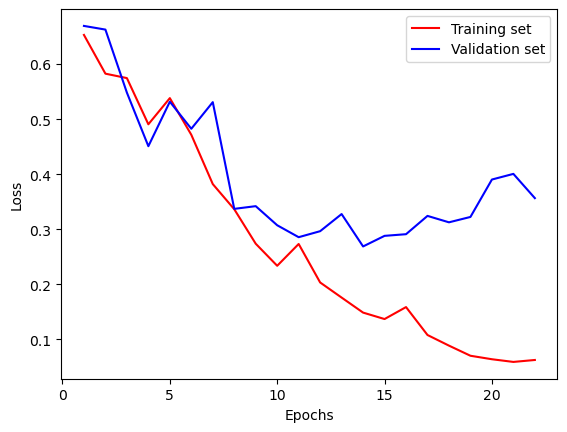

In [7]:
loss = bf.history['loss']
val_loss = bf.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

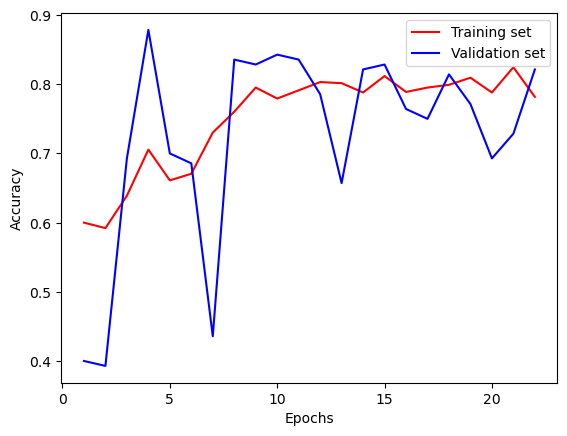

In [8]:
loss = bf.history['accuracy']
val_loss = bf.history['val_accuracy']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

## Test set results

In [20]:
yt = model.predict(Xt_emb)

for i in range(len(yt)):
    for j in range(len(yt[i])):
        if yt[i,j] > 0.5:
            yt[i,j] = int(1)
        else:
            yt[i,j] = int(0)

yt = np.array(yt, dtype=int)

7/7 [==============================] - 5s 646ms/step


In [31]:
yt_labels = []
for i in range(len(yt)):
    label = ''
    # deceptivenesss labeling
    if yt[i,0] == 1:
        label += 'TRUTHFUL'
    else:
        label += 'DECEPTIVE'
    
    # sentiment labeling
    if yt[i,1] == 1:
        label += 'POSITIVE'
    else:
        label += 'NEGATIVE'
    
    yt_labels.append(label)


In [36]:
print(f"len(yt_labels)-->{len(yt_labels)}")

with open("named results.txt", "w") as txt_file:
    for line in yt_labels:
        txt_file.write(line + "\n") # works with any number of elements in a line

len(yt_labels)-->200
